In [5]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier, VotingClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from transformers import BertModel, BertTokenizer
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.optim as optim
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import seaborn as sns

In [4]:
import re
import emoji
import pandas as pd

# Load data
train_df = pd.read_csv("/kaggle/input/caste-and-migration-hate-speech-detection/train.csv")
dev_df = pd.read_csv("/kaggle/input/caste-and-migration-hate-speech-detection/dev.csv")
df = pd.concat([train_df, dev_df], ignore_index=True)

# Function to clean each text
def preprocess_text(text):
    # Replace mentions
    text = re.sub(r'@\w+', '<USER>', text)
    
    # Replace hashtags
    text = re.sub(r'#\w+', '<HASHTAG>', text)
    
    # Convert emojis to text (e.g., 😊 -> :smiling_face_with_smiling_eyes:)
    text = emoji.demojize(text, delimiters=(" ", " "))  # adds spaces around emoji descriptions
    
    # Optional: Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

# Apply preprocessing to your column (assuming it's called 'text')
df['text'] = df['text'].apply(preprocess_text)
df.sample(10)

,id,text,label
3815,5406,Let them go. It’s good for tamilians and Tamil...,1
5703,1964,டேய் இவன் சொல்றதுதான் உண்மைடா கண்டிப்பாக அடிச்...,0
1183,6898,தேவர் பட்டம் இன்னும் நிறைய சாதிகளுக்கு உண்டு,0
4206,6489,விஜயநகர பேரரசின் நாயக்க மன்னர்களின்.ஆட்சி காலத...,0
2482,6266,​ <USER> pmk vck is dividing hindus by caste,1
5790,7164,இவர்கள் தொல்லை தாங்க முடியாமல் தான் அந்த ஏழு ம...,0
1970,56,நான் இந்தியன். நான் எனது இந்திய சகோதர சகோதரிகள...,0
5434,5069,Neenga Tamil nadu la irundhu veliya velaiku po...,0
487,3924,Sikkiram vadakan pundaya veati kollunga,1
6125,5881,I didn't know Hindi people are endangered spec...,0


In [4]:
texts = df['text'].tolist()
labels = df['label'].tolist()
len(texts), len(labels)

(6299, 6299)

In [8]:
from transformers import XLMRobertaTokenizer, XLMRobertaModel

tokenizer = XLMRobertaTokenizer.from_pretrained('xlm-roberta-base')
model = XLMRobertaModel.from_pretrained('xlm-roberta-base')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

XLMRobertaModel(
  (embeddings): XLMRobertaEmbeddings(
    (word_embeddings): Embedding(250002, 768, padding_idx=1)
    (position_embeddings): Embedding(514, 768, padding_idx=1)
    (token_type_embeddings): Embedding(1, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): XLMRobertaEncoder(
    (layer): ModuleList(
      (0-11): 12 x XLMRobertaLayer(
        (attention): XLMRobertaAttention(
          (self): XLMRobertaSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): XLMRobertaSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine

In [9]:
def tokenize_texts(texts):
    return tokenizer(texts, padding=True, truncation=True, return_tensors='pt', max_length=128)

class TextDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels
        self.tokenized_data = tokenize_texts(texts)

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        return {
            'input_ids': self.tokenized_data['input_ids'][idx],
            'attention_mask': self.tokenized_data['attention_mask'][idx],
            'label': self.labels[idx]
        }

dataset = TextDataset(texts, labels)
dataloader = DataLoader(dataset, batch_size=16, shuffle=False)

In [11]:
all_embeddings = []
# Forward pass
with torch.no_grad():
    for batch in dataloader:
        inputs = {k: v.to(device) for k, v in batch.items() if k in ['input_ids', 'attention_mask']}
        outputs = model(**inputs)
        cls_embeddings = outputs.last_hidden_state[:, 0, :]  # CLS token
        all_embeddings.append(cls_embeddings.cpu())
        
X = torch.cat(all_embeddings).numpy()
y = np.array(labels)

# Save embeddings
np.save("bert_embeddings.npy", X)

In [13]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

In [15]:
models = [
    LogisticRegression(max_iter=1000),
    RandomForestClassifier(n_estimators=100),
    SVC(kernel='rbf'),
    MultinomialNB(),
    KNeighborsClassifier(n_neighbors=5),
    GradientBoostingClassifier(),
    XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    LGBMClassifier()
]
model_names = ['Logistic Regression', 'Random Forest', 'SVM', 'Naive Bayes', 'KNN', 'Gradient Boosting', 'XGBoost', 'LightGBM']

results = {}

for model, name in zip(models, model_names):
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_val_scaled)
    
    acc = accuracy_score(y_val, y_pred)
    f1_macro = f1_score(y_val, y_pred, average='macro')  # <-- Macro F1
    cm = confusion_matrix(y_val, y_pred)
    
    results[name] = {
        'Model': model,
        'Accuracy': acc,
        'Macro F1 Score': f1_macro,
        'Confusion Matrix': cm
    }
    
    print(f"{name} -> Accuracy: {acc:.4f}, Macro F1 Score: {f1_macro:.4f}")
    print("Confusion Matrix:\n", cm)
    print("-" * 50)

Logistic Regression -> Accuracy: 0.6548, Macro F1 Score: 0.5987
Confusion Matrix:
 [[648 150]
 [285 177]]
--------------------------------------------------
Random Forest -> Accuracy: 0.7794, Macro F1 Score: 0.7302
Confusion Matrix:
 [[760  38]
 [240 222]]
--------------------------------------------------
SVM -> Accuracy: 0.6405, Macro F1 Score: 0.4105
Confusion Matrix:
 [[797   1]
 [452  10]]
--------------------------------------------------
Naive Bayes -> Accuracy: 0.6254, Macro F1 Score: 0.5174
Confusion Matrix:
 [[692 106]
 [366  96]]
--------------------------------------------------
KNN -> Accuracy: 0.6413, Macro F1 Score: 0.6165
Confusion Matrix:
 [[564 234]
 [218 244]]
--------------------------------------------------
Gradient Boosting -> Accuracy: 0.6992, Macro F1 Score: 0.6294
Confusion Matrix:
 [[714  84]
 [295 167]]
--------------------------------------------------
XGBoost -> Accuracy: 0.7643, Macro F1 Score: 0.7321
Confusion Matrix:
 [[700  98]
 [199 263]]
------------

In [16]:
voting_clf = VotingClassifier(estimators=[
    ('lr', models[0]), ('rf', models[1]), ('svm', models[2])], voting='hard')
voting_clf.fit(X_train_scaled, y_train)
y_pred_voting = voting_clf.predict(X_val_scaled)
acc_voting = accuracy_score(y_val, y_pred_voting)
f1_voting = f1_score(y_val, y_pred_voting, average='macro')
cm_voting = confusion_matrix(y_val, y_pred_voting)

results['Voting Classifier'] = {
    'Model': voting_clf,
    'Accuracy': acc_voting,
    'Macro F1 Score': f1_voting,
    'Confusion Matrix': cm_voting
}

stacking_clf = StackingClassifier(
    estimators=[('lr', models[0]), ('rf', models[1]), ('svm', models[2])],
    final_estimator=LogisticRegression()
)
stacking_clf.fit(X_train_scaled, y_train)
y_pred_stacking = stacking_clf.predict(X_val_scaled)
acc_stacking = accuracy_score(y_val, y_pred_stacking)
f1_stacking = f1_score(y_val, y_pred_stacking, average='macro')
cm_stacking = confusion_matrix(y_val, y_pred_stacking)

results['Stacking Classifier'] = {
    'Model': stacking_clf,
    'Accuracy': acc_stacking,
    'Macro F1 Score': f1_stacking,
    'Confusion Matrix': cm_stacking
}

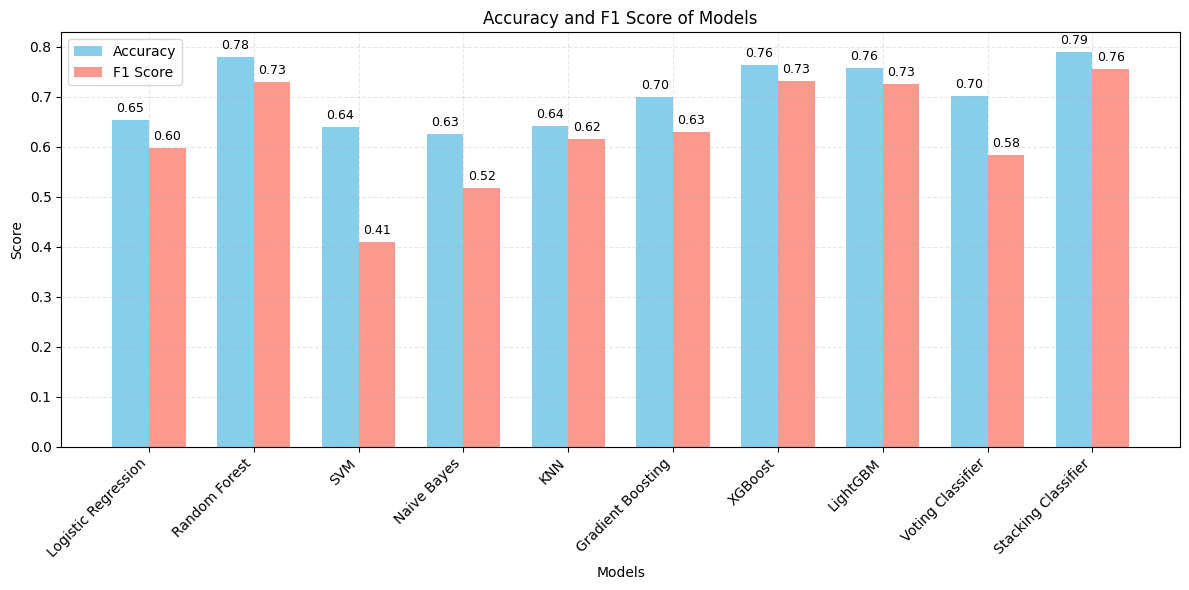


Confusion Matrix for Logistic Regression:
[[648 150]
 [285 177]]


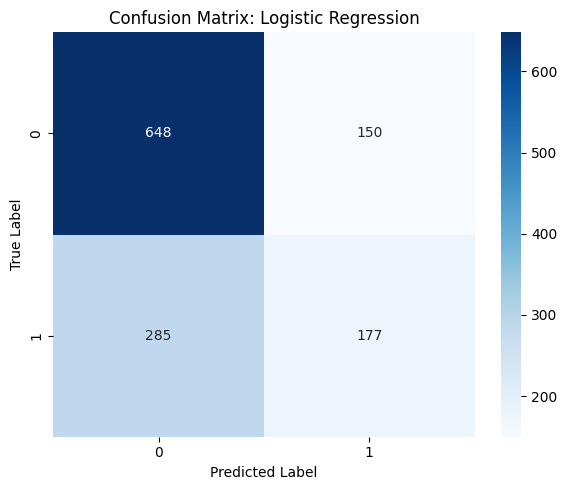


Confusion Matrix for Random Forest:
[[760  38]
 [240 222]]


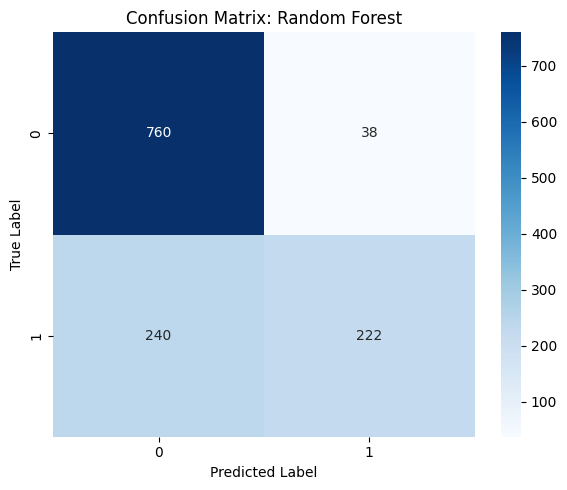


Confusion Matrix for SVM:
[[797   1]
 [452  10]]


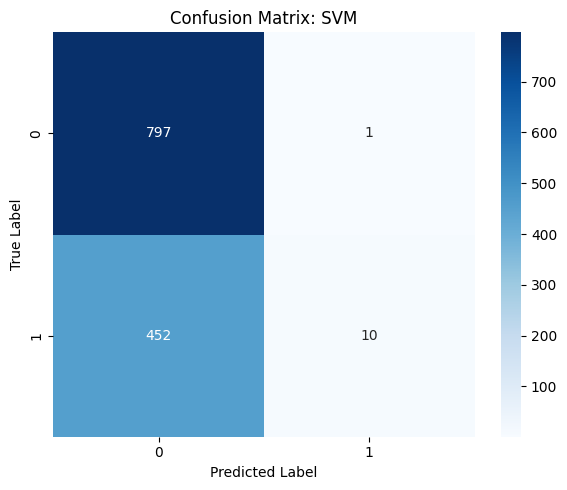


Confusion Matrix for Naive Bayes:
[[692 106]
 [366  96]]


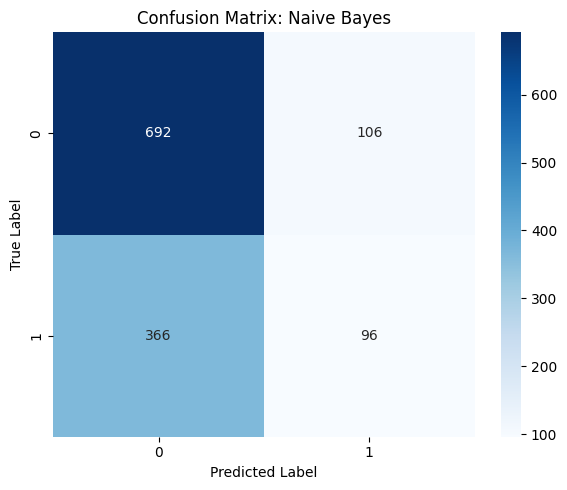


Confusion Matrix for KNN:
[[564 234]
 [218 244]]


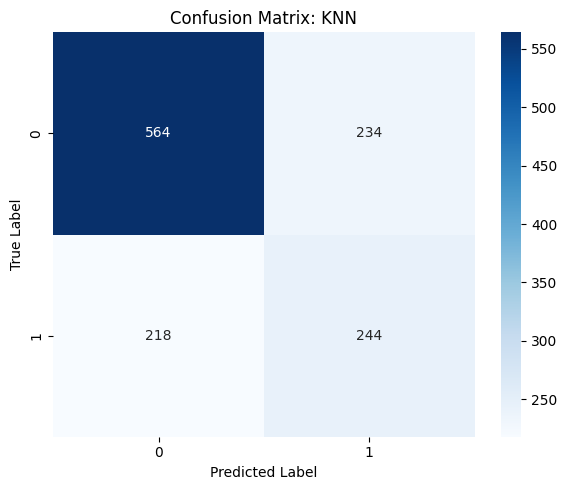


Confusion Matrix for Gradient Boosting:
[[714  84]
 [295 167]]


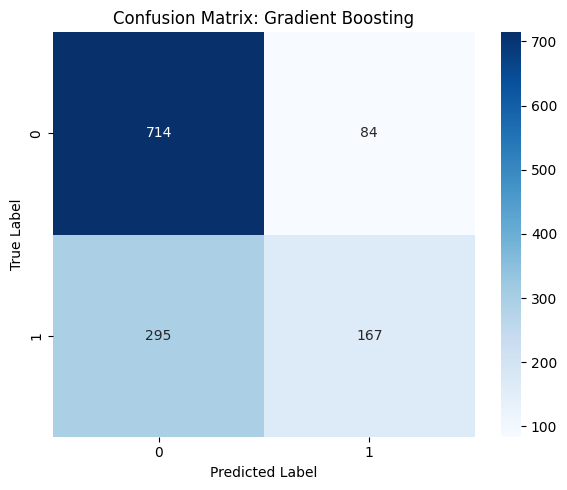


Confusion Matrix for XGBoost:
[[700  98]
 [199 263]]


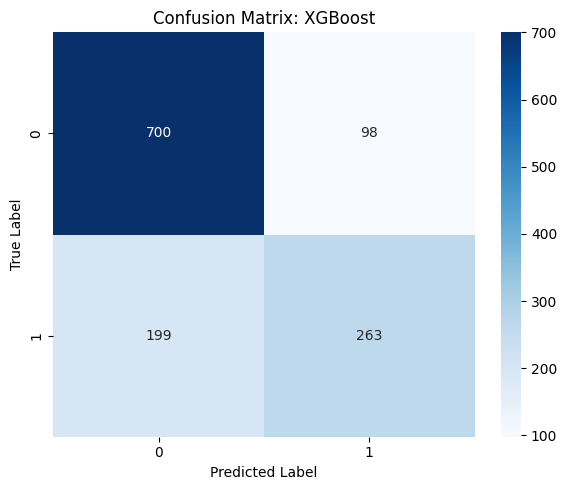


Confusion Matrix for LightGBM:
[[695 103]
 [202 260]]


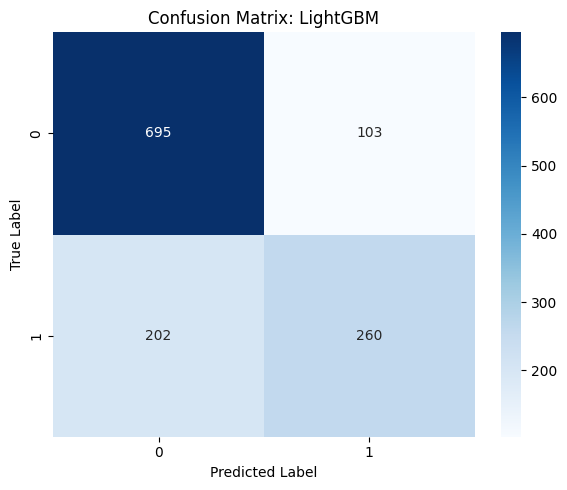


Confusion Matrix for Voting Classifier:
[[778  20]
 [355 107]]


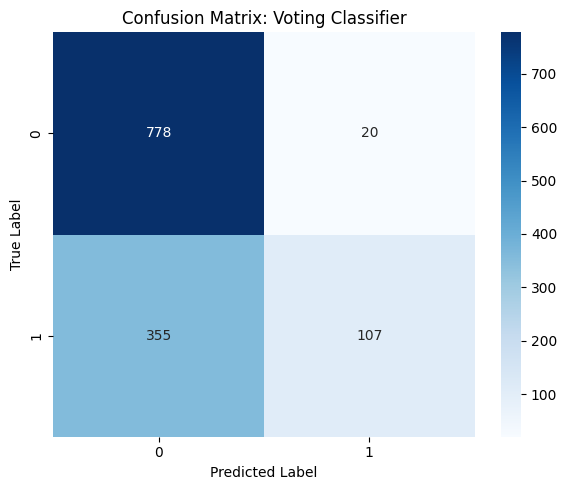


Confusion Matrix for Stacking Classifier:
[[733  65]
 [200 262]]


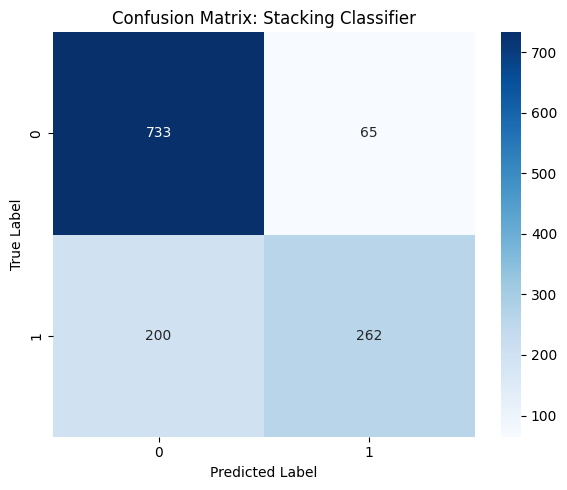

In [17]:
model_labels = list(results.keys())
accuracies = [results[m]['Accuracy'] for m in model_labels]
f1_scores = [results[m]['Macro F1 Score'] for m in model_labels]

fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(len(model_labels))
bar_width = 0.35

bars1 = ax.bar(x - bar_width/2, accuracies, bar_width, label='Accuracy', color='skyblue')
bars2 = ax.bar(x + bar_width/2, f1_scores, bar_width, label='F1 Score', color='salmon', alpha=0.8)

# Annotate bars with values on top
for bar in bars1:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, height + 0.01, f'{height:.2f}', ha='center', va='bottom', fontsize=9)

for bar in bars2:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, height + 0.01, f'{height:.2f}', ha='center', va='bottom', fontsize=9)

ax.set_xlabel('Models')
ax.set_ylabel('Score')
ax.set_title('Accuracy and F1 Score of Models')
ax.set_xticks(x)
ax.set_xticklabels(model_labels, rotation=45, ha='right')
ax.legend()
plt.tight_layout()
plt.grid(True, linestyle='--', alpha=0.3)
plt.show()

# ==========================
# Plot Confusion Matrices
# ==========================
for model_name in model_labels:
    print(f"\nConfusion Matrix for {model_name}:")
    cm = results[model_name]['Confusion Matrix']
    print(cm)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix: {model_name}")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.tight_layout()
    plt.show()